# Running `ws3` and `libcbm` as a two-stage sequential pipeline

## Install `ws3` and `libcbm` packages

In [1]:
%pip install -U git+https://github.com/gparadis/ws3@dev

  Cloning https://github.com/gparadis/ws3 (to revision dev) to /tmp/pip-req-build-2405ie2u
  Running command git clone --filter=blob:none --quiet https://github.com/gparadis/ws3 /tmp/pip-req-build-2405ie2u
  Resolved https://github.com/gparadis/ws3 to commit 0aecbeb7b8955a8f7a438abfb0127431c0af1273
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ws3
ws3.__path__

['/media/data/home/eghasemi/.virtualenvs/foo/lib/python3.10/site-packages/ws3']

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main

  Cloning https://github.com/cat-cfs/libcbm_py.git (to revision main) to /tmp/pip-req-build-mhg466aq
  Running command git clone --filter=blob:none --quiet https://github.com/cat-cfs/libcbm_py.git /tmp/pip-req-build-mhg466aq
  Resolved https://github.com/cat-cfs/libcbm_py.git to commit db920e2613e592833a7db22d48eaecc6690a4649
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
import libcbm
libcbm.__path__

['/media/data/home/eghasemi/.virtualenvs/foo/lib/python3.10/site-packages/libcbm']

In [6]:
import ws3.forest

In [7]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
fm = ws3.forest.ForestModel(model_name='tsa17',
                            model_path='./data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [9]:
fm.import_landscape_section()

In [10]:
fm.import_areas_section()

0

In [11]:
fm.import_yields_section()

In [12]:
fm.import_actions_section()

In [13]:
fm.import_transitions_section()

In [14]:
fm.initialize_areas()

In [15]:
fm.add_null_action()

In [16]:
fm.reset_actions()

In [17]:
from util import schedule_harvest_areacontrol

In [18]:
sch = schedule_harvest_areacontrol(fm)

## Hard-link ForestModel to libcbm

In [19]:
import pandas as pd

### Compile yield data

In [20]:
species_classifier_colname = 'species'
leading_species_classifier_colname = 'leading_species'

In [21]:
nv = 100 # this MIGHT have to match the number of ages classes in sit_age_classes (not sure)

In [22]:
data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 
        species_classifier_colname:[], leading_species_classifier_colname:[], 
        **{'v%i' % i:[] for i in range(nv + 1)}}

In [23]:
#data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 'foo':[], 'bar':[], 
#        **{'v%i' % i:[] for i in range(nv + 1)}}

In [24]:
canfi_species = pd.read_csv('data/canfi_species_modified.csv')
canfi_species.set_index('canfi_species', inplace=True)

In [25]:
leading_species_from_dtype_key = {} # we will need this later (as leading_species needs to be a "classifier" in libcbm
for dtype_key, ytype, curves in fm.yields[:-1]:
    if ytype != 'a': continue
    for yname, curve in curves:
        for i in range(5): data['theme%i' % i].append(dtype_key[i])
        species = 'softwood' if int(yname[-4:]) < 1200 else 'hardwood' # CANFI species codes happen to be sorted by softwood/hardwood 
        leading_species_from_dtype_key[dtype_key] = species
        data[species_classifier_colname].append(species)
        data[leading_species_classifier_colname].append(species) # just a weird libcbm data model thing...
        #data['foo'].append(species)
        #data['bar'].append(species) # just a weird libcbm data model thing...
        for i in range(nv + 1): data['v%i' % i].append(curve[i * fm.period_length])

In [26]:
sit_yield = pd.DataFrame(data)

In [27]:
sit_yield

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,265,?,265,softwood,softwood,0.0,35.0,215.0,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0
1,?,?,387,?,387,softwood,softwood,0.0,80.0,343.0,...,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0
2,?,?,335,?,335,hardwood,hardwood,0.0,131.0,263.0,...,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0
3,?,?,344,?,344,softwood,softwood,0.0,90.0,331.0,...,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0
4,?,?,306,?,306,softwood,softwood,0.0,46.0,276.0,...,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0
5,?,?,365,?,365,softwood,softwood,0.0,112.0,460.0,...,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0
6,?,?,388,?,388,softwood,softwood,0.0,256.0,501.0,...,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0
7,?,?,1085,?,1085,softwood,softwood,0.0,0.0,41.0,...,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
8,?,?,400,?,400,softwood,softwood,0.0,273.0,504.0,...,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0
9,?,?,307,?,307,softwood,softwood,0.0,213.0,439.0,...,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0


In [28]:
sit_yield_csv_path = 'data/libcbm_model_files/sit_yield.csv'
sit_yield.to_csv(sit_yield_csv_path, index=False)

### Compile inventory

In [29]:
names = ['_', 'theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'age', 'area']
sit_inventory = pd.read_csv('data/woodstock_model_files/tsa17.are', 
                            delimiter=' ', header=None, names=names)

In [30]:
sit_inventory.head()

,_,theme0,theme1,theme2,theme3,theme4,age,area
0,*A,tsa17,0,257,1211.0,257,124,7.546382
1,*A,tsa17,0,265,304.0,265,54,2.113438
2,*A,tsa17,0,265,304.0,265,64,9.107906
3,*A,tsa17,0,265,304.0,265,74,57.913632
4,*A,tsa17,0,265,304.0,265,84,15.225806


In [31]:
sit_inventory.drop('_', axis=1, inplace=True)

In [32]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,age,area
0,tsa17,0,257,1211.0,257,124,7.546382
1,tsa17,0,265,304.0,265,54,2.113438
2,tsa17,0,265,304.0,265,64,9.107906
3,tsa17,0,265,304.0,265,74,57.913632
4,tsa17,0,265,304.0,265,84,15.225806
...,...,...,...,...,...,...,...
521,tsa17,1,734,100.0,734,261,19.763159
522,tsa17,1,734,100.0,734,291,15.690830
523,tsa17,1,735,100.0,735,113,19.302217
524,tsa17,1,1103,100.0,1103,284,5.720041


In [33]:
def _leading_species(dtype_key):
    for mask, leading_species in leading_species_from_dtype_key.items():
        if fm.match_mask(mask, dtype_key):
            return leading_species
        
def __leading_species(r):
    dtype_key = tuple(str(r['theme%i' % i]) for i in range(5))
    return _leading_species(dtype_key)

In [34]:
sit_inventory[species_classifier_colname] = sit_inventory.apply(__leading_species, axis=1)
sit_inventory['using_age_class'] = 'FALSE'
sit_inventory['delay'] = 0
sit_inventory['landclass'] = 0
sit_inventory['historic_disturbance'] = 'fire'
sit_inventory['last_pass_disturbance'] = sit_inventory.apply(lambda r: 'fire' if r['theme2'] == r['theme4'] else 'harvest', axis=1)

In [35]:
names = ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', species_classifier_colname,
         'using_age_class', 'age', 'area', 'delay', 'landclass', 
         'historic_disturbance', 'last_pass_disturbance']
sit_inventory = sit_inventory[names]

In [36]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa17,0,257,1211.0,257,hardwood,FALSE,124,7.546382,0,0,fire,fire
1,tsa17,0,265,304.0,265,softwood,FALSE,54,2.113438,0,0,fire,fire
2,tsa17,0,265,304.0,265,softwood,FALSE,64,9.107906,0,0,fire,fire
3,tsa17,0,265,304.0,265,softwood,FALSE,74,57.913632,0,0,fire,fire
4,tsa17,0,265,304.0,265,softwood,FALSE,84,15.225806,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,tsa17,1,734,100.0,734,softwood,FALSE,261,19.763159,0,0,fire,fire
522,tsa17,1,734,100.0,734,softwood,FALSE,291,15.690830,0,0,fire,fire
523,tsa17,1,735,100.0,735,softwood,FALSE,113,19.302217,0,0,fire,fire
524,tsa17,1,1103,100.0,1103,softwood,FALSE,284,5.720041,0,0,fire,fire


In [37]:
sit_inventory_csv_path = 'data/libcbm_model_files/sit_inventory.csv'
sit_inventory.to_csv(sit_inventory_csv_path , index=False)

### Compile classifiers

In [38]:
data = {'classifier_id':[], 'name':[], 'description':[]}
for i in range(5):
    data['classifier_id'].append(i+1)
    data['name'].append('_CLASSIFIER')
    data['description'].append('theme%i' % i)
    for v in fm.theme_basecodes(i):
        data['classifier_id'].append(i+1)
        data['name'].append(v)
        data['description'].append(v) # these are not very good descriptions, but will not affect CBM model output

data['classifier_id'].append(6)
data['name'].append('_CLASSIFIER')
data['description'].append(species_classifier_colname) 

data['classifier_id'].append(6)
data['name'].append('softwood')
data['description'].append('softwood') 

data['classifier_id'].append(6)
data['name'].append('hardwood')
data['description'].append('hardwood') 

sit_classifiers = pd.DataFrame(data)

In [39]:
sit_classifiers

,classifier_id,name,description
0,1,_CLASSIFIER,theme0
1,1,tsa17,tsa17
2,2,_CLASSIFIER,theme1
3,2,0,0
4,2,1,1
...,...,...,...
116,5,388,388
117,5,734,734
118,6,_CLASSIFIER,species
119,6,softwood,softwood


In [40]:
sit_classifiers_csv_path = 'data/libcbm_model_files/sit_classifiers.csv'
sit_classifiers.to_csv(sit_classifiers_csv_path, index=False)

### Compile disturbance types

In [41]:
data = {'id':['harvest', 'fire'], 
        'name':['harvest', 'fire']}
sit_disturbance_types = pd.DataFrame(data)

### Compile age classes

In [42]:
data = {'name':['age_0'],
        'class_size':[0],
        'start_year':[0],
        'end_year':[0]}
for i, ac in enumerate(range(period_length, max_age+period_length, period_length)):
    data['name'].append('age_%i' % (i+1))
    data['class_size'].append(period_length)
    data['start_year'].append(ac - period_length + 1)
    data['end_year'].append(ac)
sit_age_classes = pd.DataFrame(data)

In [43]:
sit_age_classes

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


In [44]:
sit_age_classes_csv_path = 'data/libcbm_model_files/sit_age_classess.csv'
sit_age_classes.to_csv(sit_age_classes_csv_path, index=False)

### Compile events

In [45]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'MinYearsSinceDist',
           'MaxYearsSinceDist',
           'LastDistTypeID',
           'MinTotBiomassC',
           'MaxTotBiomassC',
           'MinSWMerchBiomassC',
           'MaxSWMerchBiomassC',
           'MinHWMerchBiomassC',
           'MaxHWMerchBiomassC',
           'MinTotalStemSnagC',
           'MaxTotalStemSnagC',	
           'MinSWStemSnagC',
           'MaxSWStemSnagC',
           'MinHWStemSnagC',
           'MaxHWStemSnagC',
           'MinTotalStemSnagMerchC',
           'MaxTotalStemSnagMerchC',
           'MinSWMerchStemSnagC',
           'MaxSWMerchStemSnagC',
           'MinHWMerchStemSnagC',
           'MaxHWMerchStemSnagC',
           'efficiency',
           'sort_type',
           'target_type',
           'target',
           'disturbance_type',
           'disturbance_year']

In [46]:
data = {c:[] for c in columns}

In [47]:
for dtype_key, age, area, acode, period, _ in sch:
    for i in range(5): data['theme%i' % i].append(dtype_key[i])
    data[species_classifier_colname].append(_leading_species(dtype_key))
    data['using_age_class'].append('FALSE')
    data['min_softwood_age'].append(1)
    data['max_softwood_age'].append(999)
    data['min_hardwood_age'].append(1)
    data['max_hardwood_age'].append(999)
    for c in columns[11:-6]: data[c].append(-1)
    data['efficiency'].append(1)
    data['sort_type'].append(3) # oldest first (see Table 3-3 in the CBM-CFS3 user guide)
    data['target_type'].append('A') # area target
    data['target'].append(area)
    data['disturbance_type'].append(acode)
    data['disturbance_year'].append(period*fm.period_length)
sit_events = pd.DataFrame(data)

In [48]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa17,1,335,1211.0,335,hardwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,7.701704,harvest,10
1,tsa17,1,335,1211.0,335,hardwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,52.185584,harvest,10
2,tsa17,1,335,1211.0,335,hardwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,19.481384,harvest,10
3,tsa17,1,335,1211.0,335,hardwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,9.258742,harvest,10
4,tsa17,1,357,500.0,357,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,13.125411,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,tsa17,1,734,100.0,734,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,18.513157,harvest,10
184,tsa17,1,734,100.0,734,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,12.229234,harvest,10
185,tsa17,1,734,100.0,734,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,4.382848,harvest,10
186,tsa17,1,734,100.0,734,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,4.605761,harvest,10


In [49]:
sit_events_csv_path = 'data/libcbm_model_files/sit_events.csv'
sit_events.to_csv(sit_events_csv_path, index=False)

### Compile transitions

In [50]:
au_table = pd.read_csv('data/yldmerged.csv')
au_table1 = au_table.set_index('AU')
au_table2 = au_table.set_index('AU')

In [51]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'disturbance_type',
           'to_theme0',
           'to_theme1',
           'to_theme2',
           'to_theme3',
           'to_theme4',
           'to_%s' % species_classifier_colname,
           'regen_delay',
           'reset_age',
           'percent']
data = {c:[] for c in columns}
for acode in fm.transitions:
    if acode != 'harvest': continue
    for smask in fm.transitions[acode]:
        tmask, tprop, _, _, _, _, _ = fm.transitions[acode][smask][''][0]
        for i in range(5): data['theme%i' % i].append(smask[i])
        data[species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
        data['using_age_class'].append('FALSE')
        data['min_softwood_age'].append(1)
        data['max_softwood_age'].append(999)
        data['min_hardwood_age'].append(1)
        data['max_hardwood_age'].append(999)
        data['disturbance_type'].append('harvest')
        for i in range(5): data['to_theme%i' % i].append(tmask[i])
        data['to_%s' % species_classifier_colname].append('softwood' if au_table2.loc[int(tmask[4])].canfi_species < 1200 else 'hardwood')
        data['regen_delay'].append(0)
        data['reset_age'].append(0)
        data['percent'].append(100)
sit_transitions = pd.DataFrame(data)

In [52]:
sit_transitions

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,disturbance_type,to_theme0,to_theme1,to_theme2,to_theme3,to_theme4,to_species,regen_delay,reset_age,percent
0,?,?,265,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,265,softwood,0,0,100
1,?,?,387,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,387,softwood,0,0,100
2,?,?,335,?,?,hardwood,FALSE,1,999,1,...,harvest,?,?,?,?,335,hardwood,0,0,100
3,?,?,344,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,344,softwood,0,0,100
4,?,?,306,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,306,softwood,0,0,100
5,?,?,365,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,365,softwood,0,0,100
6,?,?,388,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,388,softwood,0,0,100
7,?,?,400,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,400,softwood,0,0,100
8,?,?,307,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,307,softwood,0,0,100
9,?,?,399,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,399,softwood,0,0,100


In [53]:
sit_transitions_csv_path = 'data/libcbm_model_files/sit_transitions.csv'
sit_transitions.to_csv(sit_transitions_csv_path, index=False)

### Import data into and run `libcbm`

In [54]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 

In [55]:
sit_data = None
sit_yield.columns

Index(['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'species',
       'leading_species', 'v0', 'v1', 'v2',
       ...
       'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100'],
      dtype='object', length=108)

In [56]:
sit_data = sit_reader.parse(sit_classifiers=sit_classifiers,
                            sit_disturbance_types=sit_disturbance_types,
                            sit_age_classes=sit_age_classes,
                            sit_inventory=sit_inventory,
                            sit_yield=sit_yield,
                            sit_events=sit_events,
                            sit_transitions=sit_transitions,
                            sit_eligibilities=None)

In [57]:
sit_config = {
    'mapping_config': {
        'nonforest': None,
        'species': {
            'species_classifier': species_classifier_colname,
            'species_mapping': [
                {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
            ]
        },
        'spatial_units': {
            'mapping_mode': 'SingleDefaultSpatialUnit',
            'admin_boundary': 'British Columbia',
            'eco_boundary': 'Montane Cordillera'},
        'disturbance_types': {
            'disturbance_type_mapping': [
                {'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}
            ]
        }
    }
}

In [58]:
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)

In [59]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

In [60]:
classifiers.to_pandas()

,theme0,theme1,theme2,theme3,theme4,species
0,1,2,44,63,105,115
1,1,2,37,61,98,114
2,1,2,37,61,98,114
3,1,2,37,61,98,114
4,1,2,37,61,98,114
...,...,...,...,...,...,...
521,1,3,52,53,113,114
522,1,3,52,53,113,114
523,1,3,18,53,79,114
524,1,3,13,53,74,114


In [61]:
inventory.to_pandas()

,inventory_id,age,spatial_unit,afforestation_pre_type_id,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,1,124,42,-1.0,7.546382,0,0,2,2
1,2,54,42,-1.0,2.113438,0,0,2,2
2,3,64,42,-1.0,9.107906,0,0,2,2
3,4,74,42,-1.0,57.913632,0,0,2,2
4,5,84,42,-1.0,15.225806,0,0,2,2
...,...,...,...,...,...,...,...,...,...
521,522,261,42,-1.0,19.763159,0,0,2,2
522,523,291,42,-1.0,15.690830,0,0,2,2
523,524,113,42,-1.0,19.302217,0,0,2,2
524,525,284,42,-1.0,5.720041,0,0,2,2


In [62]:
from libcbm.model.cbm.cbm_output import CBMOutput

cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map)

In [63]:
sit.disturbance_name_map

{0: '', 1: 'harvest', 2: 'fire'}

In [64]:
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator

In [65]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps              = 200,
        classifiers          = classifiers,
        inventory            = inventory,
        pre_dynamics_func    = rule_based_processor.pre_dynamics_func,
        reporting_func       = cbm_output.append_simulation_result,
        backend_type = BackendType.numpy
    )

In [66]:
cbm_output.classifiers.to_pandas()

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species
0,1,0,tsa17,0,257,1211.0,257,hardwood
1,2,0,tsa17,0,265,304.0,265,softwood
2,3,0,tsa17,0,265,304.0,265,softwood
3,4,0,tsa17,0,265,304.0,265,softwood
4,5,0,tsa17,0,265,304.0,265,softwood
...,...,...,...,...,...,...,...,...
141438,709,200,tsa17,1,734,100.0,734,softwood
141439,710,200,tsa17,1,734,100.0,734,softwood
141440,711,200,tsa17,1,734,100.0,734,softwood
141441,712,200,tsa17,1,734,100.0,734,softwood


#### Pool Results

In [67]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), left_on=["identifier", "timestep"], right_on=["identifier", "timestep"])

In [68]:
# pi.head()

<Axes: xlabel='Year'>

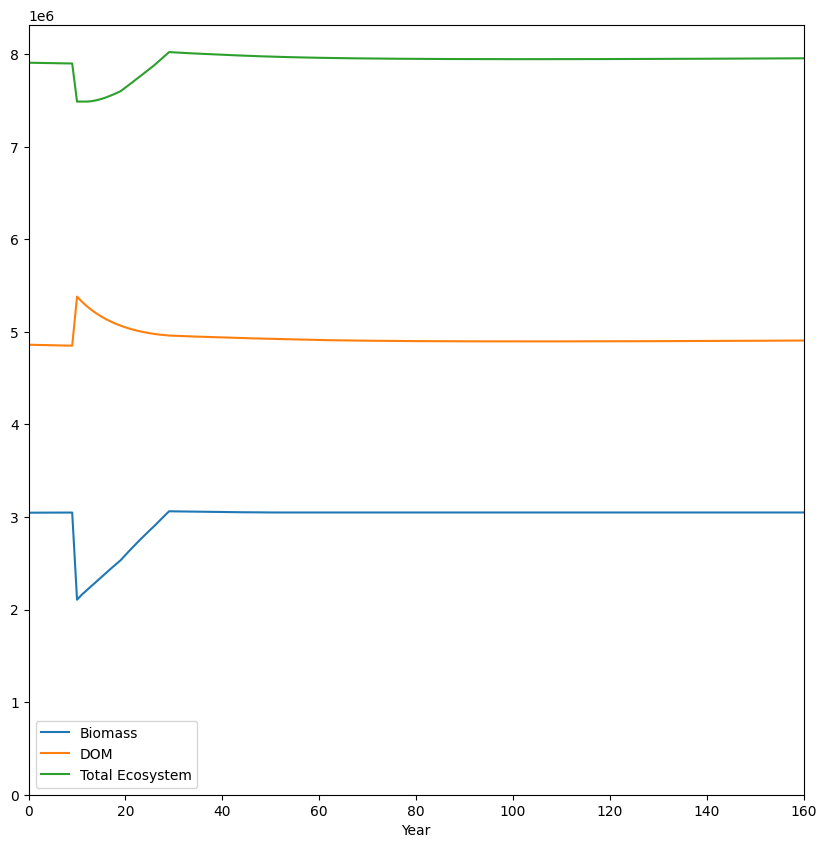

In [69]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))

#### State Variable Results

In [70]:
si = cbm_output.state.to_pandas()

In [71]:
# si.head()

<Axes: xlabel='timestep'>

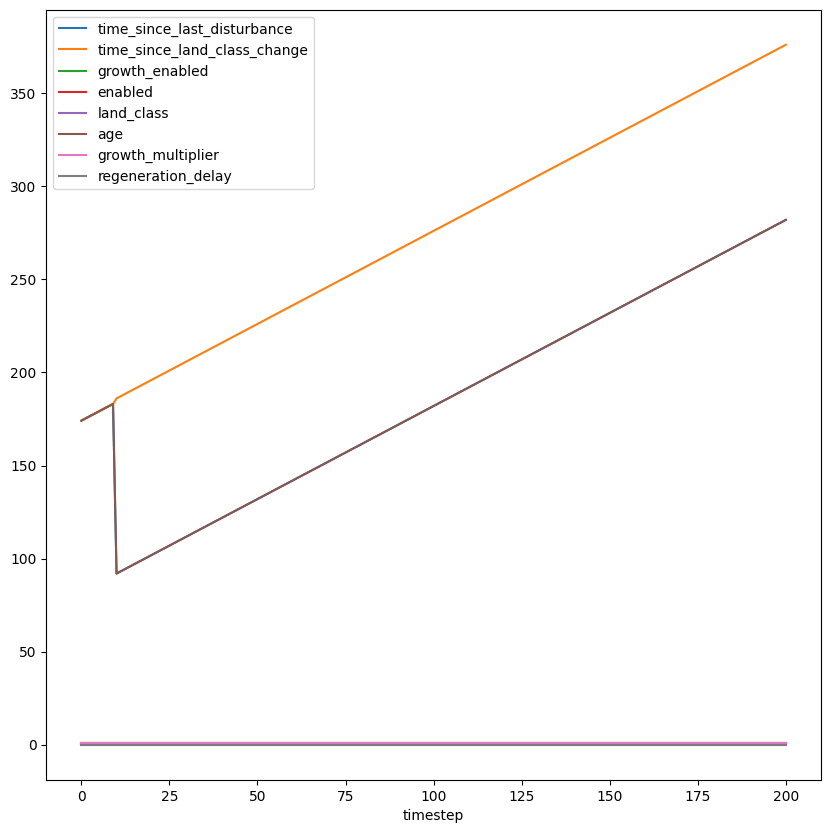

In [72]:
state_variables = ['timestep', 'time_since_last_disturbance', 'time_since_land_class_change',
 'growth_enabled', 'enabled', 'land_class', 'age', 'growth_multiplier', 'regeneration_delay']
si[state_variables].groupby('timestep').mean().plot(figsize=(10,10))

#### Flux Indicators

In [73]:
fi = cbm_output.flux.to_pandas()

In [74]:
# fi.head()

In [75]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

<Axes: xlabel='timestep'>

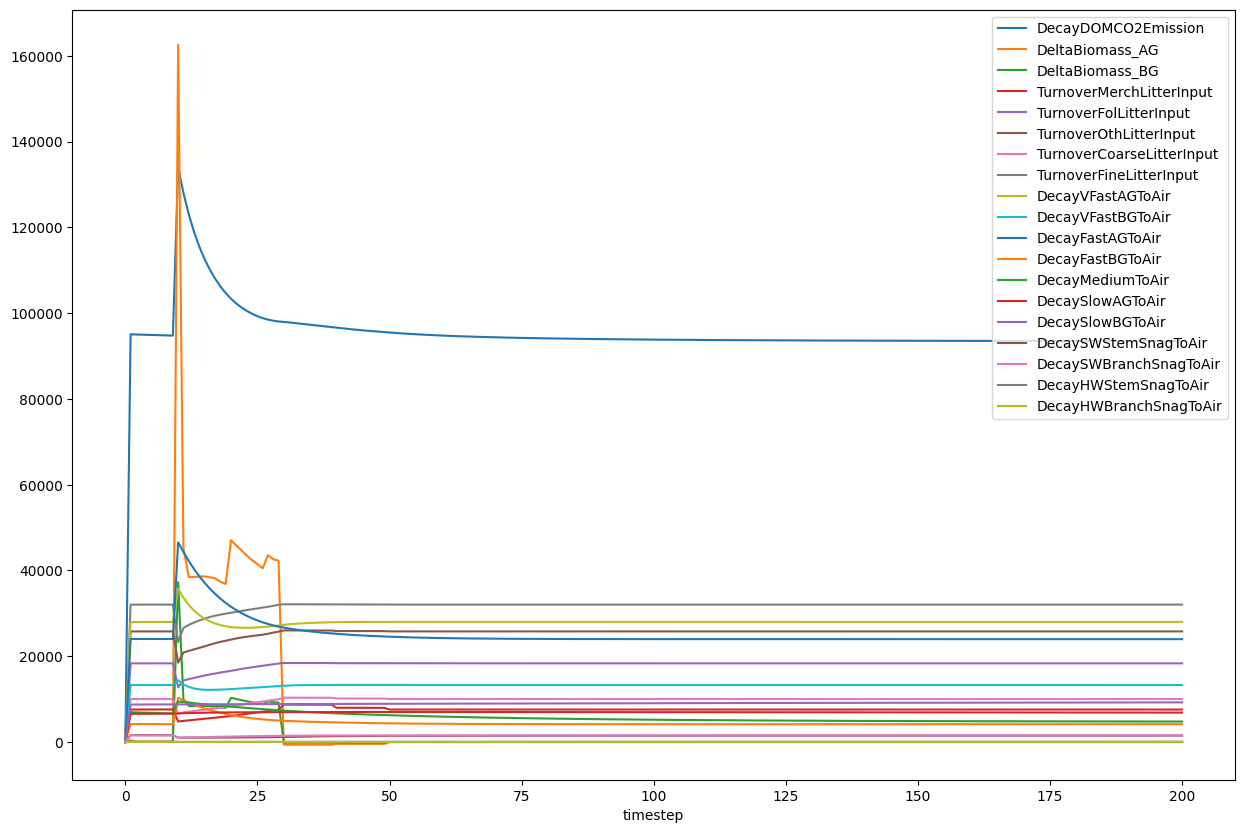

In [76]:
fi[["timestep"]+annual_process_fluxes].groupby("timestep").sum().plot(figsize=(15,10))

#### Disturbance Statistics

In [77]:
rule_based_processor.sit_event_stats_by_timestep[1]

In [78]:
# rule_based_processor.sit_events

#### Appendix

##### SIT source data

In [79]:
sit.sit_data.age_classes

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


In [80]:
sit.sit_data.inventory

,theme0,theme1,theme2,theme3,theme4,species,age,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,tsa17,0,257,1211.0,257,hardwood,124,7.546382,0,0,fire,fire
1,tsa17,0,265,304.0,265,softwood,54,2.113438,0,0,fire,fire
2,tsa17,0,265,304.0,265,softwood,64,9.107906,0,0,fire,fire
3,tsa17,0,265,304.0,265,softwood,74,57.913632,0,0,fire,fire
4,tsa17,0,265,304.0,265,softwood,84,15.225806,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...
521,tsa17,1,734,100.0,734,softwood,261,19.763159,0,0,fire,fire
522,tsa17,1,734,100.0,734,softwood,291,15.690830,0,0,fire,fire
523,tsa17,1,735,100.0,735,softwood,113,19.302217,0,0,fire,fire
524,tsa17,1,1103,100.0,1103,softwood,284,5.720041,0,0,fire,fire


In [81]:
sit.sit_data.classifiers

,id,name
0,1,theme0
1,2,theme1
2,3,theme2
3,4,theme3
4,5,theme4
5,6,species


In [82]:
sit.sit_data.classifier_values

,classifier_id,name,description
1,1,tsa17,tsa17
3,2,0,0
4,2,1,1
6,3,335,335
7,3,354,354
...,...,...,...
115,5,711,711
116,5,388,388
117,5,734,734
119,6,softwood,softwood


In [83]:
sit.sit_data.disturbance_types

,sit_disturbance_type_id,id,name
0,1,harvest,harvest
1,2,fire,fire


In [84]:
sit.sit_data.disturbance_events

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,MinYearsSinceDist,MaxYearsSinceDist,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,time_step
0,tsa17,1,335,1211.0,335,hardwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,7.701704,harvest,10
1,tsa17,1,335,1211.0,335,hardwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,52.185584,harvest,10
2,tsa17,1,335,1211.0,335,hardwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,19.481384,harvest,10
3,tsa17,1,335,1211.0,335,hardwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,9.258742,harvest,10
4,tsa17,1,357,500.0,357,softwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,13.125411,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,tsa17,1,734,100.0,734,softwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,18.513157,harvest,10
184,tsa17,1,734,100.0,734,softwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,12.229234,harvest,10
185,tsa17,1,734,100.0,734,softwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,4.382848,harvest,10
186,tsa17,1,734,100.0,734,softwood,1,999,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,SORT_BY_SW_AGE,Area,4.605761,harvest,10


In [85]:
sit.sit_data.transition_rules

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,disturbance_type,theme0_tr,theme1_tr,theme2_tr,theme3_tr,theme4_tr,species_tr,regeneration_delay,reset_age,percent
0,?,?,265,?,?,softwood,1,999,harvest,?,?,?,?,265,softwood,0,0,100.0
1,?,?,387,?,?,softwood,1,999,harvest,?,?,?,?,387,softwood,0,0,100.0
2,?,?,335,?,?,hardwood,1,999,harvest,?,?,?,?,335,hardwood,0,0,100.0
3,?,?,344,?,?,softwood,1,999,harvest,?,?,?,?,344,softwood,0,0,100.0
4,?,?,306,?,?,softwood,1,999,harvest,?,?,?,?,306,softwood,0,0,100.0
5,?,?,365,?,?,softwood,1,999,harvest,?,?,?,?,365,softwood,0,0,100.0
6,?,?,388,?,?,softwood,1,999,harvest,?,?,?,?,388,softwood,0,0,100.0
7,?,?,400,?,?,softwood,1,999,harvest,?,?,?,?,400,softwood,0,0,100.0
8,?,?,307,?,?,softwood,1,999,harvest,?,?,?,?,307,softwood,0,0,100.0
9,?,?,399,?,?,softwood,1,999,harvest,?,?,?,?,399,softwood,0,0,100.0


In [86]:
sit.sit_data.yield_table

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,265,?,265,softwood,softwood,0.0,35.0,215.0,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0
1,?,?,387,?,387,softwood,softwood,0.0,80.0,343.0,...,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0
2,?,?,335,?,335,hardwood,hardwood,0.0,131.0,263.0,...,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0
3,?,?,344,?,344,softwood,softwood,0.0,90.0,331.0,...,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0
4,?,?,306,?,306,softwood,softwood,0.0,46.0,276.0,...,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0
5,?,?,365,?,365,softwood,softwood,0.0,112.0,460.0,...,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0
6,?,?,388,?,388,softwood,softwood,0.0,256.0,501.0,...,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0
7,?,?,1085,?,1085,softwood,softwood,0.0,0.0,41.0,...,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
8,?,?,400,?,400,softwood,softwood,0.0,273.0,504.0,...,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0
9,?,?,307,?,307,softwood,softwood,0.0,213.0,439.0,...,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0


In [87]:
import json

In [88]:
print(json.dumps(sit.config, indent=4, sort_keys=True))

{
    "mapping_config": {
        "disturbance_types": {
            "disturbance_type_mapping": [
                {
                    "default_dist_type": "Clearcut harvesting without salvage",
                    "user_dist_type": "harvest"
                },
                {
                    "default_dist_type": "Wildfire",
                    "user_dist_type": "fire"
                }
            ]
        },
        "nonforest": null,
        "spatial_units": {
            "admin_boundary": "British Columbia",
            "eco_boundary": "Montane Cordillera",
            "mapping_mode": "SingleDefaultSpatialUnit"
        },
        "species": {
            "species_classifier": "species",
            "species_mapping": [
                {
                    "default_species": "Softwood forest type",
                    "user_species": "softwood"
                },
                {
                    "default_species": "Hardwood forest type",
                    "user_spec

## Soft-link `ws3` and `libcbm`

In [92]:
sit_config.update({'import_config':{
                       'classifiers':       {'type':'csv', 'params':{'path':'sit_classifiers.csv'}},
                       'disturbance_types': {'type':'csv', 'params':{'path':'sit_disturbance_types.csv'}},
                       'age_classes':       {'type': 'csv', 'params': {'path': 'sit_age_classes.csv'}},
                       'inventory':         {'type': 'csv', 'params': {'path': 'sit_inventory.csv'}},
                       'yield':             {'type': 'csv', 'params': {'path': 'sit_yield.csv'}},
                       'events':            {'type': 'csv', 'params': {'path': 'sit_events.csv'}},
                       'transitions': 	    {'type': 'csv', 'params': {'path': 'sit_transitions.csv'}}}})

In [93]:
json.dump(sit_config, open('data/libcbm_model_files/sit_config.json', 'w'), indent=4, sort_keys=True)

In [94]:
json.load(open('data/sit_config.json'))

{'import_config': {'classifiers': {'type': 'csv',
   'params': {'path': 'sit_classifiers.csv'}},
  'disturbance_types': {'type': 'csv',
   'params': {'path': 'sit_disturbance_tyeps.csv'}},
  'age_classes': {'type': 'csv', 'params': {'path': 'sit_age_classes.csv'}},
  'inventory': {'type': 'csv', 'params': {'path': 'sit_inventory.csv'}},
  'yield': {'type': 'csv', 'params': {'path': 'sit_yield.csv'}},
  'events': {'type': 'csv', 'params': {'path': 'sit_events.csv'}},
  'transitions': {'type': 'csv', 'params': {'path': 'sit_ransitions.csv'}}},
 'mapping_config': {'nonforest': None,
  'species': {'species_classifier': 'species',
   'species_mapping': [{'user_species': 'softwood',
     'default_species': 'Softwood forest type'},
    {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}]},
  'spatial_units': {'mapping_mode': 'SingleDefaultSpatialUnit',
   'admin_boundary': 'British Columbia',
   'eco_boundary': 'Montane Cordillera'},
  'disturbance_types': {'disturbance_ty

In [95]:
sit_classifiers.to_csv('data/libcbm_model_files/sit_classifiers.csv', index=False)

In [96]:
pd.read_csv('data/libcbm_model_files/sit_classifiers.csv')

,classifier_id,name,description
0,1,_CLASSIFIER,theme0
1,1,tsa17,tsa17
2,2,_CLASSIFIER,theme1
3,2,0,0
4,2,1,1
...,...,...,...
116,5,388,388
117,5,734,734
118,6,_CLASSIFIER,species
119,6,softwood,softwood


In [97]:
sit_disturbance_types.to_csv('data/libcbm_model_files/sit_disturbance_types.csv', index=False)

In [98]:
pd.read_csv('data/libcbm_model_files/sit_disturbance_types.csv')

,id,name
0,harvest,harvest
1,fire,fire


In [99]:
sit_age_classes.to_csv('data/libcbm_model_files/sit_age_classes.csv', index=False)

In [100]:
pd.read_csv('data/libcbm_model_files/sit_age_classes.csv')

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


In [101]:
sit_inventory.to_csv('data/libcbm_model_files/sit_inventory.csv', index=False)

In [102]:
pd.read_csv('data/libcbm_model_files/sit_inventory.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa17,0,257,1211.0,257,hardwood,False,124,7.546382,0,0,fire,fire
1,tsa17,0,265,304.0,265,softwood,False,54,2.113438,0,0,fire,fire
2,tsa17,0,265,304.0,265,softwood,False,64,9.107906,0,0,fire,fire
3,tsa17,0,265,304.0,265,softwood,False,74,57.913632,0,0,fire,fire
4,tsa17,0,265,304.0,265,softwood,False,84,15.225806,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,tsa17,1,734,100.0,734,softwood,False,261,19.763159,0,0,fire,fire
522,tsa17,1,734,100.0,734,softwood,False,291,15.690830,0,0,fire,fire
523,tsa17,1,735,100.0,735,softwood,False,113,19.302217,0,0,fire,fire
524,tsa17,1,1103,100.0,1103,softwood,False,284,5.720041,0,0,fire,fire


In [103]:
sit_yield.to_csv('data/libcbm_model_files/sit_yield.csv', index=False)

In [104]:
pd.read_csv('data/libcbm_model_files/sit_yield.csv')

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,265,?,265,softwood,softwood,0.0,35.0,215.0,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0
1,?,?,387,?,387,softwood,softwood,0.0,80.0,343.0,...,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0,326.0
2,?,?,335,?,335,hardwood,hardwood,0.0,131.0,263.0,...,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0
3,?,?,344,?,344,softwood,softwood,0.0,90.0,331.0,...,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0
4,?,?,306,?,306,softwood,softwood,0.0,46.0,276.0,...,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0,273.0
5,?,?,365,?,365,softwood,softwood,0.0,112.0,460.0,...,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0,472.0
6,?,?,388,?,388,softwood,softwood,0.0,256.0,501.0,...,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0,466.0
7,?,?,1085,?,1085,softwood,softwood,0.0,0.0,41.0,...,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0,58.0
8,?,?,400,?,400,softwood,softwood,0.0,273.0,504.0,...,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0,465.0
9,?,?,307,?,307,softwood,softwood,0.0,213.0,439.0,...,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0,427.0


In [105]:
sit_events.to_csv('data/libcbm_model_files/sit_events.csv', index=False)

In [106]:
pd.read_csv('data/libcbm_model_files/sit_events.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa17,1,335,1211.0,335,hardwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,7.701704,harvest,10
1,tsa17,1,335,1211.0,335,hardwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,52.185584,harvest,10
2,tsa17,1,335,1211.0,335,hardwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,19.481384,harvest,10
3,tsa17,1,335,1211.0,335,hardwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,9.258742,harvest,10
4,tsa17,1,357,500.0,357,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,13.125411,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,tsa17,1,734,100.0,734,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,18.513157,harvest,10
184,tsa17,1,734,100.0,734,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,12.229234,harvest,10
185,tsa17,1,734,100.0,734,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,4.382848,harvest,10
186,tsa17,1,734,100.0,734,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,4.605761,harvest,10


In [107]:
sit_transitions.to_csv('data/libcbm_model_files/sit_transitions.csv', index=False)

In [108]:
pd.read_csv('data/libcbm_model_files/sit_transitions.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,disturbance_type,to_theme0,to_theme1,to_theme2,to_theme3,to_theme4,to_species,regen_delay,reset_age,percent
0,?,?,265,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,265,softwood,0,0,100
1,?,?,387,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,387,softwood,0,0,100
2,?,?,335,?,?,hardwood,False,1,999,1,...,harvest,?,?,?,?,335,hardwood,0,0,100
3,?,?,344,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,344,softwood,0,0,100
4,?,?,306,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,306,softwood,0,0,100
5,?,?,365,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,365,softwood,0,0,100
6,?,?,388,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,388,softwood,0,0,100
7,?,?,400,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,400,softwood,0,0,100
8,?,?,307,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,307,softwood,0,0,100
9,?,?,399,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,399,softwood,0,0,100


In [109]:
sit = sit_cbm_factory.load_sit('data/libcbm_model_files/sit_config.json')

In [110]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

In [111]:
cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map)

In [112]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps              = 200,
        classifiers          = classifiers,
        inventory            = inventory,
        pre_dynamics_func    = rule_based_processor.pre_dynamics_func,
        reporting_func       = cbm_output.append_simulation_result,
        backend_type = BackendType.numpy
    )

In [113]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), left_on=["identifier", "timestep"], right_on=["identifier", "timestep"])

In [114]:
# pi.head()

<Axes: xlabel='Year'>

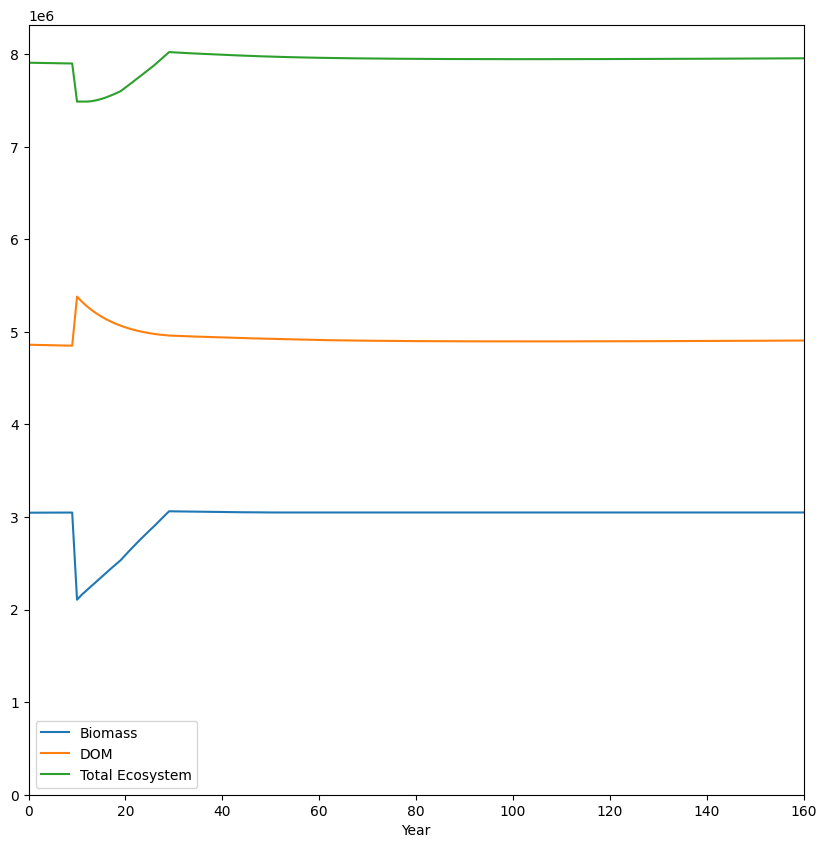

In [115]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))